# Google colab initialization

For Google colab uncomment these lines and run them to access your drive or try the second way (not tested)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
#
# sys.path.insert(1, r'/content/drive/My Drive/')

In [2]:
# Other try
# !git clone https://github.com/Alexanderstaehle/OM_project

In [3]:
# import sys
# sys.path.append("OM_project")

In [4]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras

from utils import ml_utils, visualization, data_loading, tf_models

In [5]:
RETRAIN_FLAG = True

In [6]:
RETRAIN_FLAG = False

In [7]:
filename_bs = lambda bs: ml_utils.path_from_filename(f'model_fixed_lr_diff_bs_{bs}', format_="tf")
filename_bs_lr = lambda bs, lr: ml_utils.path_from_filename(f'model_lr_{lr}_diff_bs_{bs}', format_="tf")

In [8]:
filename_bs_opt_sam = lambda bs, opt, sam: ml_utils.path_from_filename(
    f'model_fixed_lr_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")
filename_bs_lr_opt_sam = lambda bs, lr, opt, sam: ml_utils.path_from_filename(
    f'model_lr_{lr}_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")

In [9]:
def build_and_load_sam_model_weights(train, optimizer, filename, adaptive=False, rho=0.05):
    model = tf_models.build_simple_cnn_sam(train, optimizer)
    model.load_weights(filename)
    return model

In [10]:
def callback_for_filename(filename):
        train_callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filename,
                monitor='val_loss',
                mode='min',
                verbose=1,
                save_best_only=True,
                save_weights_only=True
            )
        ]
        
        return train_callbacks

In [11]:
data_loading.initialize_env()
sns.set_theme()
color_map = sns.color_palette(as_cmap=True)
ml_utils.check_tpu_gpu()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


2022-02-22 22:25:09.020535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 22:25:09.048203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 22:25:09.048390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 22:25:09.078108: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
models = {}
models_states = {}
sharpnesses = {}

# Different batch sizes with fixed learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM 

In [13]:
models_dict_fixed = {}
#models = {'fixed': {'sgd': {'sam': {}, 'asam': {}, 'none': {}}}, 'increasing': {}}

batch_sizes = [32, 64, 128, 256, 512, 1024]
#batch_sizes = [32]
lr = 0.001
training_epochs = 10

In [14]:
models_by_batch_size_fixed_lr = {}

In [15]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
#        models_by_batch_size_fixed_lr[batch_size] = model
        models[('fixed', 'sgd', 'sam', batch_size)] = model

In [16]:
if RETRAIN_FLAG:
    models_states[('fixed', 'sgd', 'sam')] = {}
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = tf_models.build_simple_cnn_sam(train, optimizer)        
        train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
        
#        models_dict_fixed[batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
#                                                             extra_callbacks=train_callbacks, verbose=1)
        models_states[('fixed', 'sgd', 'sam')][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                             extra_callbacks=train_callbacks, verbose=1)
#        models_by_batch_size_fixed_lr[batch_size] = model
        models[('fixed', 'sgd', 'sam', batch_size)] = model

In [17]:
fixed_lr_state_filename = 'model_fixed_lr_diff_bs_state'

In [18]:
if RETRAIN_FLAG:
#    ml_utils.save_model_state(models_dict_fixed, fixed_lr_state_filename)
    ml_utils.save_model_state(models_states[('fixed', 'sgd', 'sam')], fixed_lr_state_filename)
else:
#    models_dict_fixed = ml_utils.load_model_state(fixed_lr_state_filename)
    models_states[('fixed', 'sgd', 'sam')] = ml_utils.load_model_state(fixed_lr_state_filename)

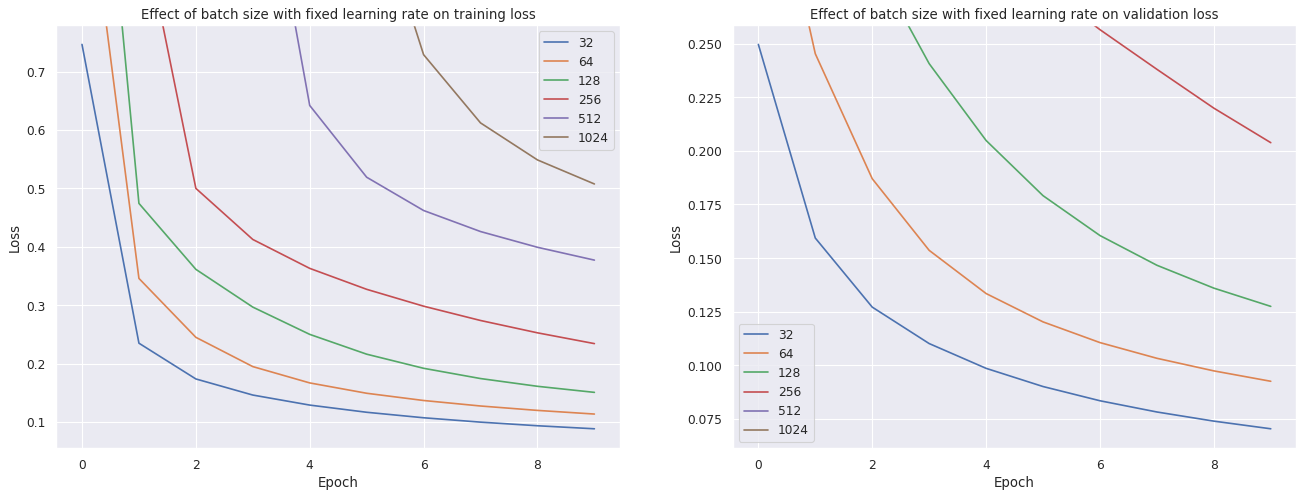

<Figure size 432x288 with 0 Axes>

In [19]:
#visualization.plot_loss_by_param(models_dict_fixed, 'batch size with fixed learning rate', 'fixed_lr_diff_bs')
visualization.plot_loss_by_param(models_states[('fixed', 'sgd', 'sam')], 'batch size with fixed learning rate', 'fixed_lr_diff_bs_SGD_SAM')

#### sharpness

In [20]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        key = ('fixed', 'sgd', 'sam', batch_size)
    #    model = models_by_batch_size_fixed_lr[batch_size]
        model = models[key]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[('fixed', 'sgd', 'sam', batch_size)] = sharpness_bs
        
        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG: 
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [21]:
sharpnesses

{('fixed', 'sgd', 'sam', 32): 3006.9595834702764,
 ('fixed', 'sgd', 'sam', 64): 3205.1751163883196,
 ('fixed', 'sgd', 'sam', 128): 3234.9225301152655,
 ('fixed', 'sgd', 'sam', 256): 2780.273842592133,
 ('fixed', 'sgd', 'sam', 512): 2549.559839894748,
 ('fixed', 'sgd', 'sam', 1024): 2093.125824727814,
 ('fixed', 'sgd', 'asam', 32): 2578.9150848823397,
 ('fixed', 'sgd', 'asam', 64): 2877.931555411324,
 ('fixed', 'sgd', 'asam', 128): 2879.804960150119,
 ('fixed', 'sgd', 'asam', 256): 2891.3174318635693,
 ('fixed', 'sgd', 'asam', 512): 2519.532132632045,
 ('fixed', 'sgd', 'asam', 1024): 2354.427266716028}

In [22]:
models_states

{('fixed', 'sgd', 'sam'): {32: <utils.ml_utils.ModelState at 0x7f3ac6de3c10>,
  64: <utils.ml_utils.ModelState at 0x7f3ac4555e80>,
  128: <utils.ml_utils.ModelState at 0x7f3ac4555df0>,
  256: <utils.ml_utils.ModelState at 0x7f3ac44f0c10>,
  512: <utils.ml_utils.ModelState at 0x7f3ac44f07c0>,
  1024: <utils.ml_utils.ModelState at 0x7f3ac4501b20>}}

#### Runtime

In [23]:
mean_times = []
convergence_epochs = []
overall_training_times = []

for batch_size in batch_sizes:
    # Compute mean epoch time, num epochs to converge, overall training time
#    state = models_dict_fixed[batch_size]
    state = models_states[('fixed', 'sgd', 'sam')][batch_size]
    mean_time_per_epoch = np.mean(state.times)
    convergence_epoch = np.argmin(state.history['val_loss'])
    overall_training_time = np.sum(state.times[:convergence_epoch])

    # Append results
    convergence_epochs.append(convergence_epoch)
    mean_times.append(mean_time_per_epoch)
    overall_training_times.append(overall_training_time)

    print("Batch size: ", batch_size)
    print("\tMean time per epoch: ", mean_time_per_epoch)
    print("\tConverged in {} epochs".format(convergence_epoch))
    print("\tOverall training time (in seconds) until convergence: ", overall_training_time)

Batch size:  32
	Mean time per epoch:  8.064194488525391
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  73.60259556770325
Batch size:  64
	Mean time per epoch:  4.661650586128235
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  42.005412578582764
Batch size:  128
	Mean time per epoch:  3.335676980018616
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  30.238672971725464
Batch size:  256
	Mean time per epoch:  2.7133270025253298
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  24.49651598930359
Batch size:  512
	Mean time per epoch:  2.478763246536255
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  22.29880452156067
Batch size:  1024
	Mean time per epoch:  2.311429762840271
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  21.15034818649292


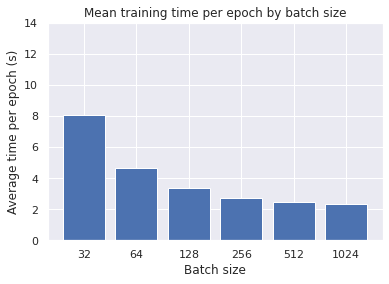

<Figure size 432x288 with 0 Axes>

In [24]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

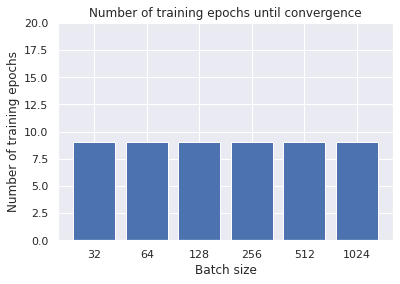

<Figure size 432x288 with 0 Axes>

In [25]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

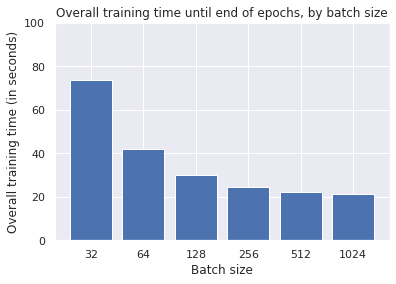

<Figure size 432x288 with 0 Axes>

In [26]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

- loss curve
- val loss curve
- final train and val loss (best) 
- sharpness of the minimizers 
- distance from initial weights

- training time
- training time per epoch 
- epochs needed to converge 
- parallelization 
- training time times sharpness

### SGD with Momentum + ASAM

In [27]:
models_dict_fixed_sgd_asam = {}
batch_sizes = [32, 64, 128, 256, 512, 1024]
#batch_sizes = [32]
lr = 0.001
training_epochs = 10

key = ('fixed', 'sgd', 'asam')

In [28]:
models_by_batch_size_fixed_lr_sgd_asam = {}

In [29]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))
        models_by_batch_size_fixed_lr_sgd_asam[batch_size] = model
        models[key + (batch_size,)] = model

In [30]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = tf_models.build_simple_cnn_sam(train, optimizer)        
        train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))
        
#        models_dict_fixed_sgd_asam[batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
#                                                             extra_callbacks=train_callbacks, verbose=1)
        models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                             extra_callbacks=train_callbacks, verbose=1)
#        models_by_batch_size_fixed_lr_sgd_asam[batch_size] = model
        models[key + (batch_size,)] = model

In [31]:
fixed_lr_sgd_asam_state_filename = 'model_fixed_lr_diff_bs_sgd_asam_state'

In [32]:
if RETRAIN_FLAG:
    #ml_utils.save_model_state(models_dict_fixed_sgd_asam, fixed_lr_sgd_asam_state_filename)
    ml_utils.save_model_state(models_states[key], fixed_lr_sgd_asam_state_filename)
else:
    #models_dict_fixed_sgd_asam = ml_utils.load_model_state(fixed_lr_sgd_asam_state_filename)
    models_states[key] = ml_utils.load_model_state(fixed_lr_sgd_asam_state_filename)

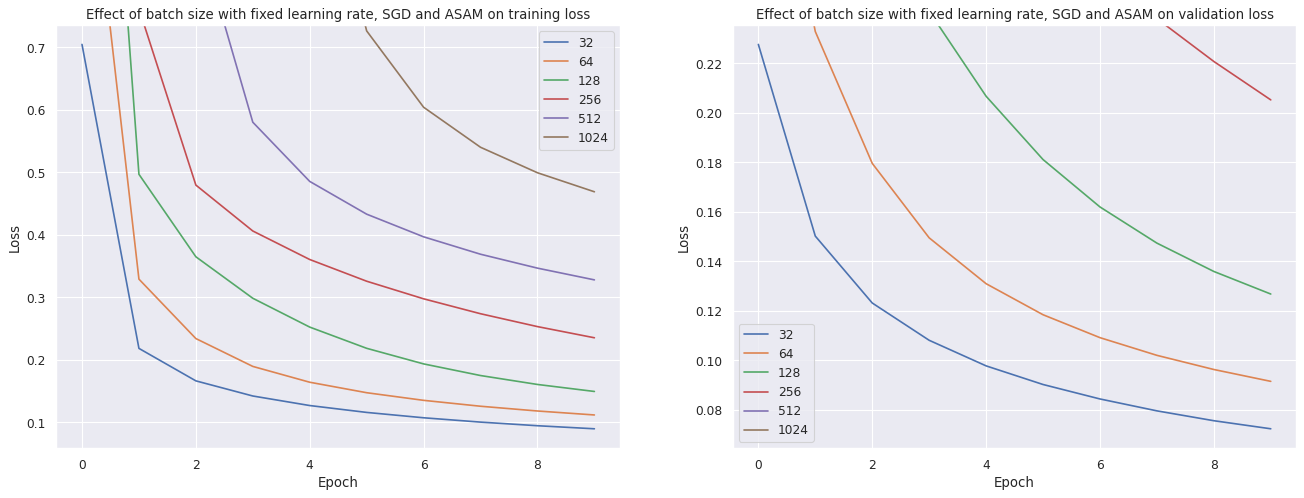

<Figure size 432x288 with 0 Axes>

In [33]:
#visualization.plot_loss_by_param(models_dict_fixed_sgd_asam, 'batch size with fixed learning rate, SGD and ASAM', 'model_fixed_lr_diff_bs_sgd_asam_state')
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, SGD and ASAM', 'model_fixed_lr_diff_bs_sgd_asam_state')

#### sharpness

In [34]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
    #    model = models_by_batch_size_fixed_lr[batch_size]
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs
        
        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG: 
    sharpnesses = ml_utils.load_sharpnesses_dict()

#### Runtime

In [35]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states, batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.712298774719239
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  68.85894680023193
Batch size:  64
	Mean time per epoch:  4.598783159255982
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  41.95453643798828
Batch size:  128
	Mean time per epoch:  3.2741246461868285
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  29.663331747055054
Batch size:  256
	Mean time per epoch:  2.724825382232666
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  24.671682834625244
Batch size:  512
	Mean time per epoch:  2.400427055358887
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  21.6072039604187
Batch size:  1024
	Mean time per epoch:  2.3027666807174683
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  20.823163986206055


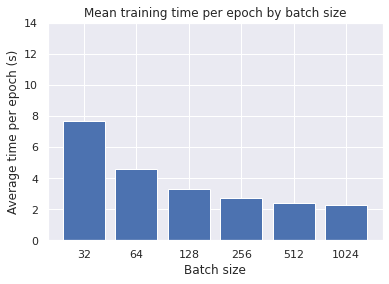

<Figure size 432x288 with 0 Axes>

In [36]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

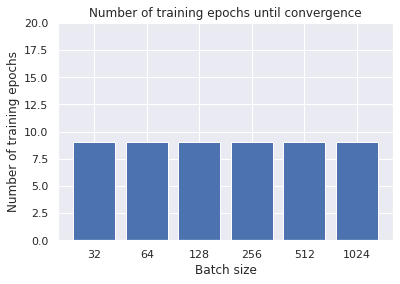

<Figure size 432x288 with 0 Axes>

In [37]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

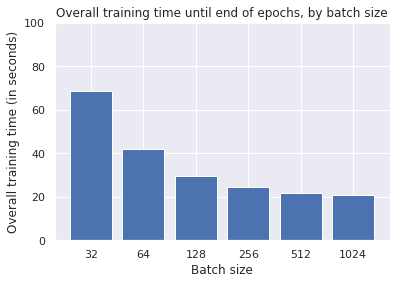

<Figure size 432x288 with 0 Axes>

In [38]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

### ADAM + SAM 

### ADAM + ASAM

## without sharpness aware minimization

### SGD with Momemtum

### ADAM

# Different batch sizes with linear increasing learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM 

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = 10

In [ ]:
models_by_batch_size_diff_lr = {}
model_history_dict_diff_lr = {}

In [ ]:
diff_lr_state_filename = 'model_diff_lr_diff_bs_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))
        models_by_batch_size_diff_lr[batch_size] = model

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive = True, rho = 2.0)       
        train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))

        model_history_dict_diff_lr[batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                      extra_callbacks=train_callbacks, verbose=1)
        models_by_batch_size_diff_lr[batch_size] = model

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(model_history_dict_diff_lr, diff_lr_state_filename)
else:
    model_history_dict_diff_lr = ml_utils.load_model_state(diff_lr_state_filename)

In [ ]:
visualization.plot_loss_by_param(model_history_dict_diff_lr, 'batch size with increasing learning rate',
                                 'diff_lr_diff_bs')

#### sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        #key = 
        model = models_by_batch_size_diff_lr[batch_size]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses_diff[batch_size] = sharpness_bs

In [ ]:
sharpnesses_diff

In [ ]:
mean_times = []
convergence_epochs = []
overall_training_times = []

for batch_size in batch_sizes:
    # Compute mean epoch time, num epochs to converge, overall training time
    state = models_dict_fixed[batch_size]
    mean_time_per_epoch = np.mean(state.times)
    convergence_epoch = np.argmin(state.history['val_loss'])
    overall_training_time = np.sum(state.times[:convergence_epoch])

    # Append results
    convergence_epochs.append(convergence_epoch)
    mean_times.append(mean_time_per_epoch)
    overall_training_times.append(overall_training_time)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)